## **Model 4: Same preprocessing as model 2 + Shallow CNN**

Since model 2 had the best performance so far after trying different preprocessing methods, we  are taking it and experimenting with it for the best arcitecture possible.

**Preprocessing exactly as model 2**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dataset with normalization
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [2]:
val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

In [3]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

**Build Shallow CNN**

In [6]:
def build_shallow_cnn(input_shape=(128,128,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model4 = build_shallow_cnn()
model4.summary()

d:\Python11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,612 (7.05 MB)

 Trainable params: 1,848,612 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

**Callbacks**

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='models/model04_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


**Compile**

In [8]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Train**

In [9]:
history4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # EarlyStopping will halt earlier
    callbacks=callbacks
)

Epoch 1/50
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6176 - loss: 0.8879
Epoch 1: val_loss improved from None to 0.42323, saving model to models/model04_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7361 - loss: 0.6636 - val_accuracy: 0.8357 - val_loss: 0.4232 - learning_rate: 0.0010
Epoch 2/50
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8607 - loss: 0.3816
Epoch 2: val_loss improved from 0.42323 to 0.28703, saving model to models/model04_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8735 - loss: 0.3557 - val_accuracy: 0.8920 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 3/50
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9197 - loss: 0.2254
Epoch 3: val_loss improved from 0.28703 to 0.25790, saving model to models/model04_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9279 - loss: 0.2139 - val_accuracy: 0.9161 - val_loss: 0.2579 - learning_rate: 0.0010
Epoch 4/50
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9596 - loss: 0.1284
Epoch 4: val_loss did not improve from 0.25790
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9617 - loss: 0.1244 - val_accuracy: 0.9080 - val_loss: 0.3147 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9750 - loss: 0.0876
Epoch 5: val_loss improved from 0.25790 to 0.21036, saving model to models/model04_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9730 - loss: 0.0890 - val_accuracy: 0.9232 - val_loss: 0.2104 - learning_rate: 0.0010
Epoch 6/50
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9756 - loss: 0.0744
Epoch 6: val_loss did not improve from 0.21036
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9750 - loss: 0.0735 - val_accuracy: 0.9304 - val_loss: 0.2240 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9854 - loss: 0.0447
Epoch 7: val_loss did not improve from 0.21036
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9845 - loss: 0.0458 - val_accuracy: 0.9241 - val_loss: 0.2884 - learning_rate: 0.0010
Epoch 8/50
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9935 - loss: 0.0271
Epoch 8: val_loss did not improve from 0.21036

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9911 - loss: 0.0314 - val_accuracy: 0.8

**Load best model**

In [10]:
best_model4 = tf.keras.models.load_model('models/model04_best.h5')

**Evaluate**

In [11]:
# Evaluate on test set
test_loss, test_acc = model4.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get final training & validation metrics
final_train_acc = history4.history['accuracy'][-1]
final_train_loss = history4.history['loss'][-1]
final_val_acc   = history4.history['val_accuracy'][-1]
final_val_loss  = history4.history['val_loss'][-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9161 - loss: 0.2211
Test accuracy: 0.9161
Test loss: 0.2211
Final training accuracy: 0.9996
Final training loss: 0.0047
Final validation accuracy: 0.9420
Final validation loss: 0.2205


**loss-curve plotting function**

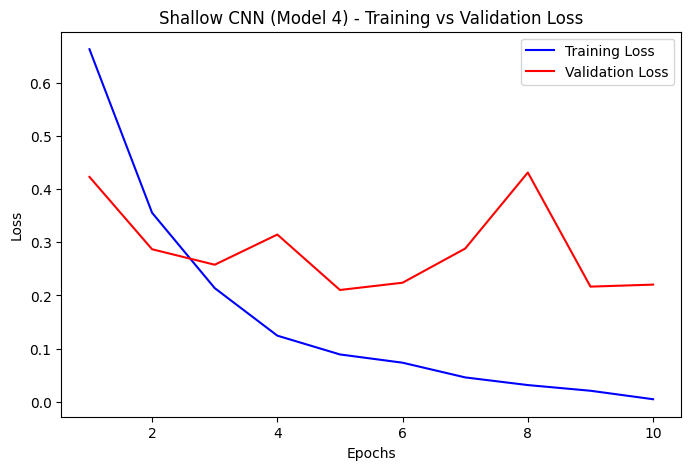

In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(history, model_name="Model"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call for Model 4
plot_loss_curves(history4, model_name="Shallow CNN (Model 4)")

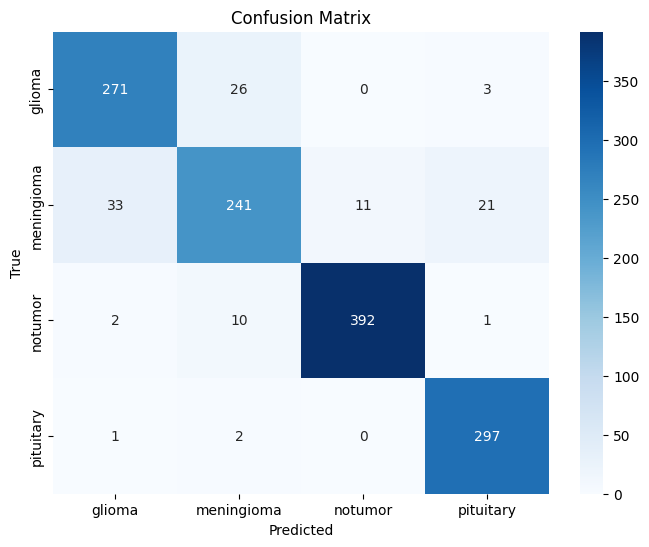


Classification Report:

              precision    recall  f1-score   support

      glioma       0.88      0.90      0.89       300
  meningioma       0.86      0.79      0.82       306
     notumor       0.97      0.97      0.97       405
   pituitary       0.92      0.99      0.95       300

    accuracy                           0.92      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.92      0.92      0.91      1311



In [5]:
from plot_utils import plot_confusion_matrix_from_dataset

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model04_best.h5", test_ds, class_names)
